<a href="https://colab.research.google.com/github/maddieiyengar/Costco_Company_Analysis/blob/main/Costco_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
# Importing libraries/ dependencies

# Summary: This data visualization process converts complex financial datasets into high-visibility charts to provide clear
# insights into Costco’s growth trends, regional performance, and market valuation. By utilizing standardized plotting
# libraries, it generates objective, data-driven graphics that facilitate a precise assessment of the company’s operational
# and market health.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import os

In [69]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    base_path = '/content/drive/MyDrive/datasets/'
    print(f"Drive mounted. Searching for files in: {base_path}")
except ImportError:
    base_path = './'
    print("Running in a local environment.")

# Loading Data for Analysis

def smart_load(keyword):
    """Searches for a file by keyword and cleans column names."""
    if not os.path.exists(base_path): return None
    all_files = os.listdir(base_path)
    matches = [f for f in all_files if keyword.lower() in f.lower()]
    if matches:
        file_path = os.path.join(base_path, matches[0])
        print(f"Loading standalone file: {matches[0]}")
        df = pd.read_csv(file_path) if file_path.endswith('.csv') else pd.read_excel(file_path)
        df.columns = df.columns.str.strip().str.lower()
        return df
    return None

def load_master_excel(file_keyword):
    """Imports every sheet from an Excel file into a dictionary of DataFrames."""
    all_files = os.listdir(base_path)
    matches = [f for f in all_files if file_keyword.lower() in f.lower() and f.endswith('.xlsx')]
    if not matches: return {}

    file_path = os.path.join(base_path, matches[0])
    print(f"Found master file: {matches[0]}. Importing all sheets...")

    # Load all sheets: returns {sheet_name: dataframe}
    dict_frames = pd.read_excel(file_path, sheet_name=None)

    cleaned_data = {}
    for sheet_name, df in dict_frames.items():
        clean_key = sheet_name.strip().lower().replace(" ", "_")
        df.columns = df.columns.str.strip().str.lower()
        cleaned_data[clean_key] = df
    return cleaned_data

# Importing Data from Sheets

# Load all sheets from costco_data
data = load_master_excel("costco_data")

# Load other supplementary files (ensure 'df' is defined here!)
standalone_files = ["membership metrics", "yoy revenue growth"]

for keyword in standalone_files:
    clean_key = keyword.replace(" ", "_")
    df = smart_load(keyword)  # Fixed: Ensure this line is NOT commented out
    if df is not None:
        data[clean_key] = df

print("\nSuccessfully loaded tables:", list(data.keys()))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive mounted. Searching for files in: /content/drive/MyDrive/datasets/
Found master file: costco_data.xlsx. Importing all sheets...
Loading standalone file: membership metrics.xlsx
Loading standalone file: YoY Revenue Growth.xlsx

Successfully loaded tables: ['incomestatement', 'balancesheet', 'cashflowstatement', 'us_sales', 'mexico_sales', 'canada_sales', 'stockprice', 'simplifiedp&l', 'ratios', 'spy', 'membership_metrics', 'yoy_revenue_growth']


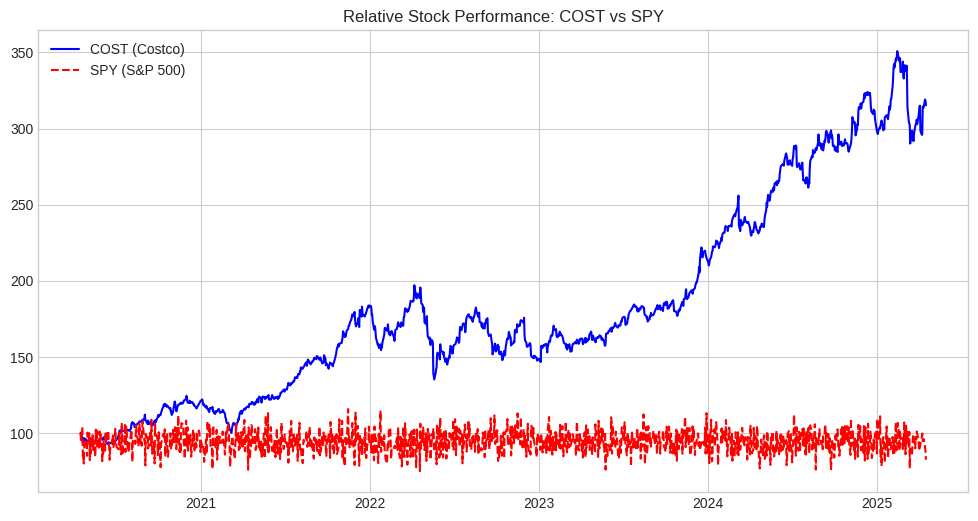

In [70]:
# Stock Performance in comparison to SPY500

costco_stock = data['stockprice'].copy()
spy_stock = data['spy'].copy()

# Ensure dates are datetime
costco_stock['date'] = pd.to_datetime(costco_stock['date'])
spy_stock['date'] = pd.to_datetime(spy_stock['date'])

# Normalize to 100 (Indexed Performance)
costco_stock = costco_stock.sort_values('date')
spy_stock = spy_stock.sort_values('date')

costco_stock['indexed'] = (costco_stock['close'] / costco_stock['close'].iloc[0]) * 100
spy_stock['indexed'] = (spy_stock['close'] / spy_stock['close'].iloc[0]) * 100

plt.figure(figsize=(12, 6))
plt.plot(costco_stock['date'], costco_stock['indexed'], label='COST (Costco)', color='blue')
plt.plot(spy_stock['date'], spy_stock['indexed'], label='SPY (S&P 500)', color='red', linestyle='--')
plt.title("Relative Stock Performance: COST vs SPY")
plt.legend()
plt.show()

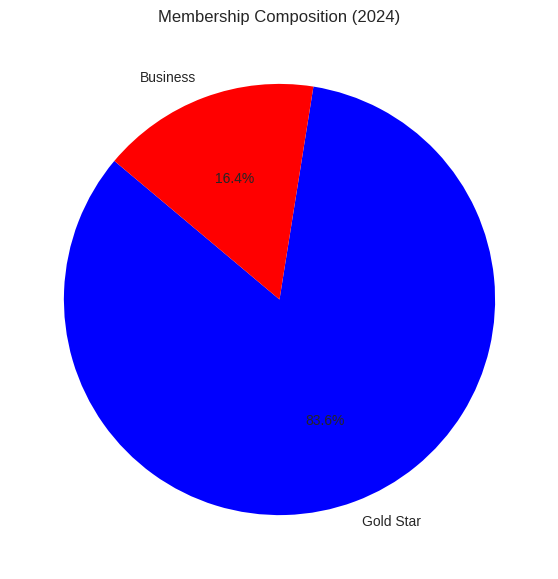

In [71]:
# Membership Composition

m_comp = data['membership_metrics']
labels = ['Gold Star', 'Business']
# Slicing from row 1 (Gold Star) and 2 (Business) from the 2024 column
sizes = [float(m_comp.iloc[1, 1]), float(m_comp.iloc[2, 1])]

plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['blue', 'red'], startangle=140)
plt.title("Membership Composition (2024)")
plt.show()

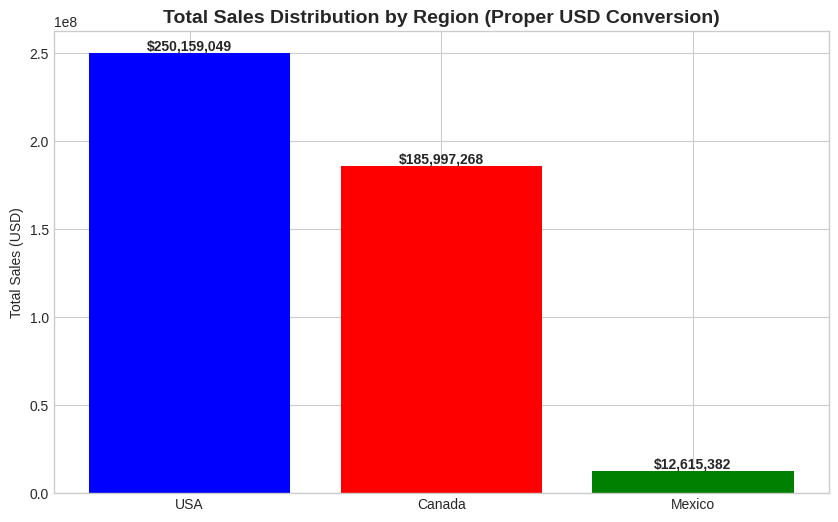

In [72]:
# Regional Sales by Country

if all(k in data for k in ['us_sales', 'canada_sales', 'mexico_sales']):
    # US is already in USD
    us_total = (data['us_sales']['price_in_usd'] * data['us_sales']['units_sold']).sum()
    # Canada: Price per unit in CAD converted to USD (Rate ~0.74)
    ca_total = (data['canada_sales']['price_per_unit'] * data['canada_sales']['units_sold'] * 0.74).sum()
    # Mexico: Price per unit in MXN converted to USD (Rate ~0.05)
    mx_total = (data['mexico_sales']['price_per_unit'] * data['mexico_sales']['units_sold'] * 0.05).sum()

    regional_sales = pd.DataFrame({
        'Region': ['USA', 'Canada', 'Mexico'],
        'Sales_USD': [us_total, ca_total, mx_total]
    }).sort_values('Sales_USD', ascending=False)

    plt.figure(figsize=(10, 6))
    bars = plt.bar(regional_sales['Region'], regional_sales['Sales_USD'], color=['blue', 'red', 'green'])
    plt.title("Total Sales Distribution by Region (Proper USD Conversion)", fontsize=14, fontweight='bold')
    plt.ylabel("Total Sales (USD)")
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'${bar.get_height():,.0f}',
                 va='bottom', ha='center', fontweight='bold')
    plt.show()

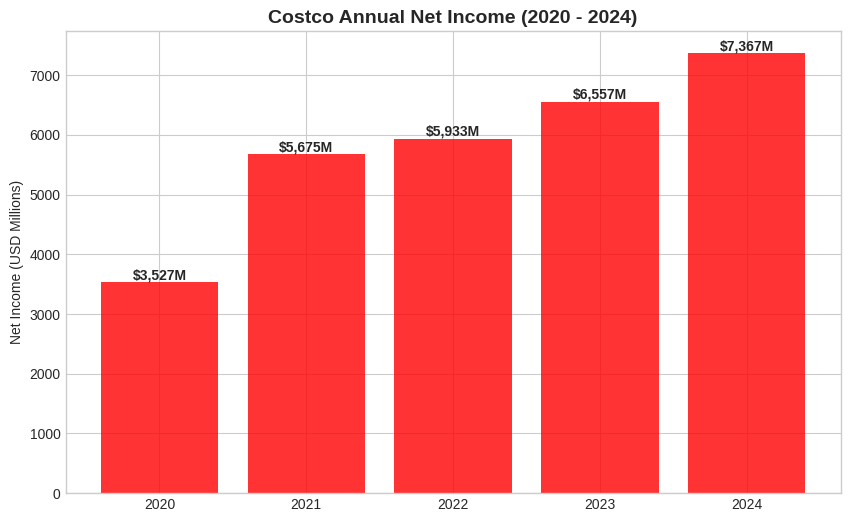

In [73]:
# Net Income

if 'simplifiedp&l' in data:
    pnl = data['simplifiedp&l'].set_index('category').transpose()
    pnl.columns = pnl.columns.str.strip().str.lower().str.replace(' ', '_')
    pnl.index = pd.to_numeric(pnl.index)
    pnl = pnl.sort_index()

    plt.figure(figsize=(10, 6))
    bars = plt.bar(pnl.index.astype(str), pnl['net_income'], color='red', alpha=0.8)
    plt.title("Costco Annual Net Income (2020 - 2024)", fontsize=14, fontweight='bold')
    plt.ylabel("Net Income (USD Millions)")
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 50, f'${yval:,.0f}M', ha='center', fontweight='bold')
    plt.show()

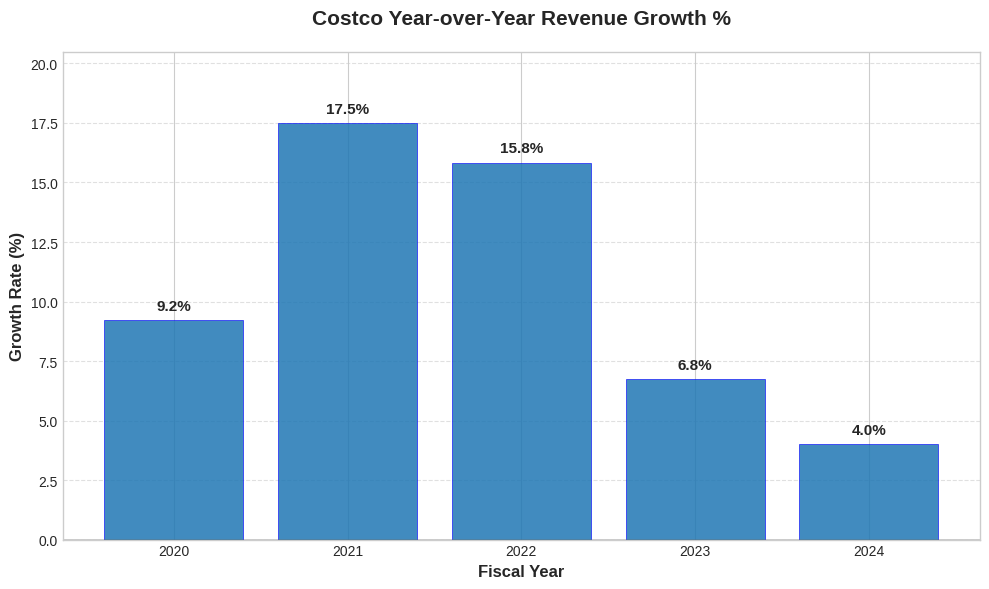

In [74]:
# Year-over-Year Growth

if 'yoy_revenue_growth' in data:
    df_growth = data['yoy_revenue_growth']

    # Standardize column names
    years = df_growth['year'].astype(str)
    growth_values = df_growth['yoy growth'] * 100 # Convert to percentage

    plt.figure(figsize=(10, 6))

    # Create the Bar Chart
    bars = plt.bar(years, growth_values, alpha=0.85, edgecolor='blue', linewidth=0.5)

    # Add a horizontal line at 0 for reference
    plt.axhline(0, color='black', linewidth=1)

    # Add Data Labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.3,
                 f'{height:.1f}%', ha='center', va='bottom',
                 fontsize=11, fontweight='bold')

    # Chart Styling
    plt.title("Costco Year-over-Year Revenue Growth %", fontsize=15, fontweight='bold', pad=20)
    plt.ylabel("Growth Rate (%)", fontsize=12, fontweight='bold')
    plt.xlabel("Fiscal Year", fontsize=12, fontweight='bold')
    plt.ylim(0, max(growth_values) + 3) # Provide space for labels
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()
else:
    print("Error: 'yoy_revenue_growth' table not found in data dictionary.")